In [1]:
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from transformers import ViTImageProcessor, VisionEncoderDecoderModel
import re
from collections import Counter
import torch
from transformers import (
    VisionEncoderDecoderModel, 
    ViTConfig, 
    GPT2Config,
    ViTImageProcessor,
    GPT2Tokenizer,
    ViTModel,
    GPT2LMHeadModel
)
from typing import List, Dict, Any
from transformers import TrainingArguments, Trainer
import os

# 1. Data


## Import

In [2]:
ds = load_dataset("CADCODER/GenCAD-Code", num_proc=16, split=["train", "test"], cache_dir="/Volumes/BIG-DATA/HUGGINGFACE_CACHE")

## Analysis

{'image': Image(mode=None, decode=True, id=None), 'deepcad_id': Value(dtype='string', id=None), 'cadquery': Value(dtype='string', id=None), 'token_count': Value(dtype='int64', id=None), 'prompt': Value(dtype='string', id=None), 'hundred_subset': Value(dtype='bool', id=None)}
147289 7355


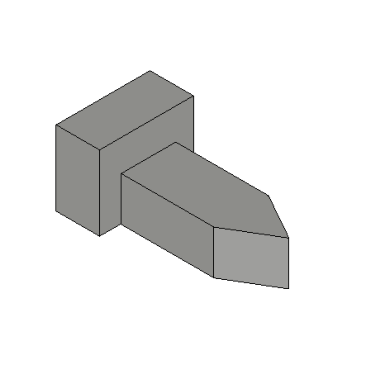

0000/00001378
_________________________
import cadquery as cq
# Generating a workplane for sketch 0
wp_sketch0 = cq.Workplane(cq.Plane(cq.Vector(0.0, -0.1953125, 0.0), cq.Vector(1.0, 0.0, 0.0), cq.Vector(0.0, 0.0, 1.0)))
loop0=wp_sketch0.moveTo(0.17730263157894738, 0.0).lineTo(0.17730263157894738, 0.38281250000000006).lineTo(0.0, 0.38281250000000006).lineTo(0.0, 0.0).close()
solid0=wp_sketch0.add(loop0).extrude(0.3046875)
solid=solid0
# Generating a workplane for sketch 1
wp_sketch1 = cq.Workplane(cq.Plane(cq.Vector(0.1796875, -0.109375, 0.0), cq.Vector(1.0, 0.0, 0.0), cq.Vector(0.0, 0.0, 1.0)))
loop1=wp_sketch1.moveTo(0.3782072368421052, 0.0).lineTo(0.5703125, 0.1140625).lineTo(0.3782072368421052, 0.22212171052631577).lineTo(0.0, 0.22212171052631577).lineTo(0.0, 0.0).close()
solid1=wp_sketch1.add(loop1).extrude(0.1796875)
solid=solid.union(solid1)

_________________________
The number of characters: 821
The number of tokens: 1195
_________________________
Generate the CADQuery code ne

In [3]:
train = ds[0]
test = ds[1]
print(train.features)
print(len(train), len(test))

example = train[1]
img = example['image']
plt.imshow(img)
plt.axis('off')
plt.show()
print(example['deepcad_id'])
print("_________________________")
print(example['cadquery'])
print("_________________________")
print("The number of characters:", len(example['cadquery']))
print("The number of tokens:", example['token_count'])
print("_________________________")
print(example['prompt'])
print("_________________________")
print(example['hundred_subset'])


The number of tokens is greater than number of characters in the query. More information about the tokenization is needed.

In [4]:
all_prompts = train['prompt'] + test['prompt']
unique_prompts = set(all_prompts)
print(f"Number of unique prompts: {len(unique_prompts)}")
if len(unique_prompts) == 1:
    print("All prompts are the same.")
else:
    print("There are different prompts in the dataset.")
    print("Sample unique prompts:", list(unique_prompts)[:5])

Number of unique prompts: 1
All prompts are the same.


In [5]:
image_sizes = [img.size for img in train[:1000]['image']]
unique_sizes = set(image_sizes)
print(f"Unique image sizes: {unique_sizes}")
print(f"Total images: {len(image_sizes)}")

Unique image sizes: {(448, 448)}
Total images: 1000


In [6]:
# Token count statistics
token_counts = train['token_count'] + test['token_count']
print(f"Token count statistics:")
print(f"  Mean: {np.mean(token_counts):.2f}")
print(f"  Median: {np.median(token_counts):.2f}")
print(f"  Min: {np.min(token_counts)}")
print(f"  Max: {np.max(token_counts)}")

Token count statistics:
  Mean: 1257.47
  Median: 1064.00
  Min: 807
  Max: 6495


In [7]:
# CAD code length analysis
cad_lengths = [len(code) for code in train['cadquery'] + test['cadquery']]
print(f"\nCAD code length statistics:")
print(f"  Mean: {np.mean(cad_lengths):.2f} characters")
print(f"  Median: {np.median(cad_lengths):.2f} characters")
print(f"  Min: {np.min(cad_lengths)} characters")
print(f"  Max: {np.max(cad_lengths)} characters")

# Check subset distribution
subset_counts = sum(train['hundred_subset'] + test['hundred_subset'])
print(f"\nHundred subset: {subset_counts} out of {len(train) + len(test)} samples")


CAD code length statistics:
  Mean: 882.21 characters
  Median: 605.00 characters
  Min: 283 characters
  Max: 8104 characters

Hundred subset: 100 out of 154644 samples


# 2. Baseline 
As I'm new to working directly with transformer models, I began by experimenting with a basic encoder-decoder architecture to validate the pipeline. Here, I used ViTModel as the image encoder and GPT-2 as the text decoder.

## CAD code generator

We'll add CAD-specific tokens, because 
- CAD code has specific repetitive syntax 
- our dataset is large enough to benefit from it

In [8]:
class CADCodeGenerator:
    def __init__(self, cad_codes, vocab_size=None, max_length=1024):
        self.max_length = max_length
        
        # Initialize tokenizer
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        self.tokenizer.pad_token = self.tokenizer.eos_token # needed for compatibility
        
        # CAD-specific tokens
        def generate_cad_specific_tokens(cad_codes, min_frequency=10):
            import_patterns = []
            method_patterns = []
            operation_patterns = []
            variable_patterns = []
            comment_patterns = []
            
            for code in cad_codes:
                # Extract import statements
                imports = re.findall(r'import\s+\w+(?:\s+as\s+\w+)?', code)
                import_patterns.extend(imports)
                
                # Extract CAD method calls (cq.something)
                methods = re.findall(r'cq\.\w+', code)
                method_patterns.extend(methods)
                
                # Extract function calls (.functionName())
                function_calls = re.findall(r'\.\w+\(', code)
                operation_patterns.extend(function_calls)

                # Extract variable names (wp_sketch, solid, loop)
                variables = re.findall(r'\b(?:wp_sketch|solid|loop)\d*\b', code)
                variable_patterns.extend(variables)
                
                # Extract assignment patterns (variable = )
                assignments = re.findall(r'\b\w+\s*=', code)
                variable_patterns.extend([a.strip() for a in assignments])
                
                # Extract comment keywords
                comments = re.findall(r'#\s*(\w+(?:\s+\w+)*)\s*$', code, re.MULTILINE)
                comment_patterns.extend([f"# {comment}" for comment in comments])
            
            # Count frequencies
            all_patterns = {
                'imports': Counter(import_patterns),
                'methods': Counter(method_patterns),
                'operations': Counter(operation_patterns),
                'variables': Counter(variable_patterns),
                'comments': Counter(comment_patterns)
            }
            
            # Collect high-frequency tokens
            cad_tokens = []
            
            for _, counter in all_patterns.items():
                frequent_tokens = [token for token, freq in counter.most_common(20) if freq >= min_frequency]
                cad_tokens.extend(frequent_tokens)
            
            # Essential CAD tokens, even if not frequent
            essential_tokens = [
                # Core CAD imports
                'import cadquery as cq',
                'cadquery',
                'cq',
                
                # Basic CAD objects
                'cq.Workplane',
                'cq.Plane',
                'cq.Vector',
                
                # Common operations
                '.moveTo(',
                '.lineTo(',
                '.circle(',
                '.rectangle(',
                '.extrude(',
                '.revolve(',
                '.union(',
                '.cut(',
                '.intersect(',
                '.fillet(',
                '.chamfer(',
                
                # 3D operations
                '.add(',
                '.subtract(',
                '.threePointArc(',
                '.close(',
                '.wire(',
                '.face(',
                '.solid(',
                
                # Variable patterns
                'wp_sketch',
                'solid',
                'loop',
                'result',
                
                # Comments
                '# Generating',
                '# Creating',
                '# sketch',
                '# workplane',
            ]

            all_tokens = list(set(cad_tokens + essential_tokens))
            return all_tokens


        special_tokens = generate_cad_specific_tokens(cad_codes[:1000], min_frequency=5)
        print(f"Generated {len(special_tokens)} CAD-specific tokens")
        print(special_tokens)
        self.tokenizer.add_special_tokens({'additional_special_tokens': special_tokens})
        
        # Update vocab size
        vocab_size = len(self.tokenizer)
        
        # Configure Vision Encoder (ViT)
        encoder_config = ViTConfig(
            image_size=448,  # Based on the dataset analysis
            patch_size=16,
            num_channels=3,
            hidden_size=768,
            num_hidden_layers=12,
            num_attention_heads=12,
            intermediate_size=3072,
        )
        
        # Configure Text Decoder (GPT2-based)
        decoder_config = GPT2Config(
            vocab_size=vocab_size,
            n_positions=max_length,
            n_embd=768,
            n_layer=12,
            n_head=12,
            max_length=max_length,
            pad_token_id=self.tokenizer.pad_token_id,
            eos_token_id=self.tokenizer.eos_token_id,
            bos_token_id=self.tokenizer.bos_token_id,
add_cross_attention=True,  # Essential for vision-encoder-decoder
            is_decoder=True,           # Enable decoder mode
        )
        
        # Create the encoder and decoder models
        encoder = ViTModel(encoder_config)
        decoder = GPT2LMHeadModel(decoder_config)
        
        # Create Vision-Encoder-Decoder Model
        self.model = VisionEncoderDecoderModel(encoder=encoder, decoder=decoder)
        
        # Configure generation parameters
        self.model.config.decoder_start_token_id = self.tokenizer.bos_token_id
        self.model.config.pad_token_id = self.tokenizer.pad_token_id
        self.model.config.eos_token_id = self.tokenizer.eos_token_id
        self.model.config.max_length = max_length
        self.model.config.early_stopping = True
        self.model.config.no_repeat_ngram_size = 3
        self.model.config.length_penalty = 2.0
        self.model.config.num_beams = 4
        
        # Image processor
        self.image_processor = ViTImageProcessor(
            size={"height": 448, "width": 448},
            do_resize=True,
            do_normalize=True,
            image_mean=[0.485, 0.456, 0.406],
            image_std=[0.229, 0.224, 0.225]
        )
        
    def preprocess_data(self, examples):
        """Preprocess images and CAD code for training"""
        # Process images
        images = [img.convert('RGB') for img in examples['image']]
        pixel_values = self.image_processor(images, return_tensors="pt")['pixel_values'] 
        
        # Tokenize CAD code
        cad_codes = examples['cadquery']
        tokenized = self.tokenizer(
            cad_codes,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        
        # Prepare labels 
        labels = tokenized['input_ids'].clone()
        # Replace padding tokens with -100 (ignore in loss)
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        return {
            'pixel_values': pixel_values,
            'labels': labels,
            'decoder_attention_mask': tokenized['attention_mask']
        }
    
    def generate_cad_code(self, image, max_length=None):
        """Generate CAD code from an image"""
        if max_length is None:
            max_length = self.max_length
            
        # Preprocess image
        if isinstance(image, str):
            image = Image.open(image).convert('RGB')
        
        pixel_values = self.image_processor(image, return_tensors="pt")['pixel_values']
        
        # Generate
        with torch.no_grad():
            generated_ids = self.model.generate(
                pixel_values,
                max_length=max_length,
                num_beams=4,
                early_stopping=True,
                no_repeat_ngram_size=3,
                length_penalty=2.0
            )
        
        # Decode
        generated_text = self.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        return generated_text

# Initialize the model
print("Initializing CAD Code Generator...")
cad_generator = CADCodeGenerator(train['cadquery'][:10000])  # Use a sample of CAD codes for initialization

Initializing CAD Code Generator...
Generated 63 CAD-specific tokens
['wp_sketch1 =', '.wire(', 'loop1=', 'wp_sketch0', '.close(', 'loop3', 'solid2', '# Generating a workplane for sketch 7', 'loop0', 'wp_sketch', '# Generating a workplane for sketch 3', '.cut(', 'import cadquery as cq', '# Generating a workplane for sketch 6', 'wp_sketch3', 'loop2', '.Plane(', '.extrude(', '.intersect(', '# workplane', '.rectangle(', '# Creating', '.union(', '# Generating a workplane for sketch 2', '.add(', 'solid', '# Generating a workplane for sketch 0', 'loop2=', 'solid1=', 'wp_sketch1', '# Generating a workplane for sketch 4', '.revolve(', 'solid=', '.solid(', '.Workplane(', 'cadquery', 'cq.Vector', '# sketch', '.circle(', 'loop0=', '.fillet(', '.moveTo(', '.face(', 'cq.Workplane', '.lineTo(', '.Vector(', 'cq.Plane', '.subtract(', 'wp_sketch2', '# Generating a workplane for sketch 1', 'cq', '# Generating', 'loop1', 'loop', '# Generating a workplane for sketch 5', '.chamfer(', 'result', '.threePointA

## Custom data collator

We have to create a custom data collator, since HuggingFace's default collators are designed for homogeneous data types. In our case, we have tensors and strings which have to be preprocessed differently. CAD code requires proper padding, while images should be normalized.


In [9]:
class CADDataCollator:    
    def __init__(self, tokenizer, image_processor, max_length=1024):
        self.tokenizer = tokenizer
        self.image_processor = image_processor
        self.max_length = max_length
    
    def __call__(self, batch: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        # Extract images and CAD codes
        images = [item['image'] for item in batch]
        cad_codes = [item['cadquery'] for item in batch]
        
        # Process images (convert to RGB if needed)
        rgb_images = [img.convert('RGB') if img.mode != 'RGB' else img for img in images]
        
        # Batch process images
        image_inputs = self.image_processor(
            rgb_images, 
            return_tensors="pt"
        )
        pixel_values = image_inputs['pixel_values']
        
        # Tokenize CAD codes with padding
        text_inputs = self.tokenizer(
            cad_codes,
            padding=True,  # Pad to longest in batch
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        
        # Prepare labels (shift right for causal LM)
        labels = text_inputs['input_ids'].clone()
        # Replace padding tokens with -100 (ignore in loss)
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        return {
            'pixel_values': pixel_values,
            'labels': labels,
            'decoder_attention_mask': text_inputs['attention_mask']
        }


## Training on a subset 


In [10]:
# Create output directory
output_dir = "./cad-model-checkpoints"
os.makedirs(output_dir, exist_ok=True)

# Configure training arguments
training_args = TrainingArguments(
    output_dir=output_dir,
    
    # Learning & Optimization
    learning_rate=5e-5,              # Conservative for vision-language
    warmup_steps=500,                # Gradual warmup
    weight_decay=0.01,               # Regularization
    
    # Batch & Memory Management  
    per_device_train_batch_size=2,   # Small due to memory constraints
    per_device_eval_batch_size=2,    
    gradient_accumulation_steps=8,   # Effective batch size = 2*8 = 16
    dataloader_num_workers=0,        # Start with 0, increase if stable
    
    # Training Schedule
    num_train_epochs=3,              # Start with few epochs
    max_steps=-1,                    # Use num_epochs instead
    
    # Evaluation & Saving
    eval_strategy="steps",           # Evaluate during training
    eval_steps=500,                  # Every 500 steps
    save_strategy="steps",           # Save checkpoints regularly
    save_steps=500,                  # Every 500 steps
    save_total_limit=3,              # Keep only last 3 checkpoints
    
    # Monitoring & Debugging
    logging_dir=f"{output_dir}/logs",
    logging_steps=100,               # Log every 100 steps
    report_to=None,                  # Disable wandb for now
    
    # Performance & Stability
    fp16=True,                       # Mixed precision (if supported)
    gradient_checkpointing=True,     # Trade compute for memory
    
    # Early Stopping & Best Model
    load_best_model_at_end=True,     # Load best checkpoint at end
    metric_for_best_model="eval_loss",
    greater_is_better=False,         # Lower loss is better

    # Data Processing
    remove_unused_columns=False,     # Keep all columns for custom data collator
    
    # Reproducibility
    seed=42,
    data_seed=42,
)

# Prepare subsets of datasets for training
def create_dataset_splits(train_data, test_data, max_train_samples=1000, max_eval_samples=100):
    """Create smaller dataset splits for initial training/testing"""
    
    # Use subset for faster iteration during development
    train_subset = train_data.select(range(min(max_train_samples, len(train_data))))
    eval_subset = test_data.select(range(min(max_eval_samples, len(test_data))))
    
    return train_subset, eval_subset

# Create dataset splits
train_dataset, eval_dataset = create_dataset_splits(train, test)


In [11]:
# Create the data collator
data_collator = CADDataCollator(
    tokenizer=cad_generator.tokenizer,
    image_processor=cad_generator.image_processor,
    max_length=512
)

# Initialize the Trainer with corrected model
trainer = Trainer(
    model=cad_generator.model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    tokenizer=cad_generator.tokenizer,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device {device} :')")

trainer.train()


C:\Users\eleon\AppData\Local\Temp\ipykernel_16080\3916487158.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\eleon\anaconda3\envs\echo-env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Device cpu :')


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

## After training
I would evaluate Valid Syntax Rate and Best IOU, as suggested.
Also I wonder if we could apply some standard computer vision techniques for evaluation. For example, consider the substraction result of the ground truth and the image that is generated from the predicted code. It might work, if the original images are generated from some code.


# How can I improve the baseline?

1. I can use a CNN pretrained on a large dataset and fine-tune it to obtain a better image encoder. Additionally, it’s possible to combine features from different layers of the ViT model.
2. For the decoder, I can experiment with larger language models and study CAD code patterns more thoroughly.
3. I can explore more effective cross-attention mechanisms between the vision and text modalities.
4. I could also design a custom multi-objective loss function, similar to those used in YOLO models.
5. There's more, but I ran out of time :)

# To read later

- https://arxiv.org/pdf/2105.09492
- https://arxiv.org/pdf/2503.23062